# TAPE Deconvolution

In [45]:
from benchmark_utils import (
  preprocess_scrna,
  split_dataset,
  create_signature,
  add_cell_types_grouped,
  create_pseudobulk_dataset,
  compute_correlations,
  perform_nnls
)

In [71]:
import anndata as ad
import pandas as pd
import numpy as np

SIGNATURE_CHOICE = "crosstissue_granular_updated"  # ["laughney", "almudena", "crosstissue_general", "crosstissue_granular_updated"]
CELL_TYPE_GROUP = "updated_granular_groups" 

from TAPE import Deconvolution
from TAPE.deconvolution import ScadenDeconvolution

In [3]:
adata = ad.read_h5ad("/home/owkin/cti_data/processed/cti_processed.h5ad")

In [4]:
signature = create_signature(adata,
                             signature_type=SIGNATURE_CHOICE,
                             group=CELL_TYPE_GROUP)
add_cell_types_grouped(adata, CELL_TYPE_GROUP)

In [6]:
adata

AnnData object with n_obs × n_vars = 329762 × 2500
    obs: 'donor_id', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'Manually_curated_celltype', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'updated_granular_groups'
    var: 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'cell_type_ontology_term_id_colors', 'default_embedding', 'hvg', 'log1p', 'neighbors', 'pca', 'schema_version', 'sex_ontology_term_id

In [24]:
adata_pseudobulk, pseudobulk, proportions = create_pseudobulk_dataset(adata=adata,
                                             n_sample=300,
                                             cell_type_group=CELL_TYPE_GROUP)

In [25]:
pseudobulk

gene_ids,ENSG00000243485,ENSG00000238009,ENSG00000239945,ENSG00000241860,ENSG00000241599,ENSG00000286448,ENSG00000229905,ENSG00000237491,ENSG00000177757,ENSG00000228794,...,ENSG00000276345,ENSG00000277856,ENSG00000275063,ENSG00000278782,ENSG00000277761,ENSG00000277836,ENSG00000278633,ENSG00000276017,ENSG00000278817,ENSG00000277196
0,0.0,0.000000,0.000000,0.436751,0.032900,0.000000,0.000000,1.358852,0.026605,1.439710,...,1.140027,0.286966,0.214764,0.000000,0.015474,0.099887,0.000000,0.00000,0.148642,0.000000
1,0.0,0.042112,0.024329,0.356552,0.072870,0.012807,0.000000,1.339357,0.022018,1.515743,...,1.229045,0.160370,0.262566,0.000000,0.000000,0.000000,0.000000,0.00761,0.172723,0.000000
2,0.0,0.120607,0.002717,0.267504,0.028509,0.000000,0.026613,1.327621,0.038371,1.583632,...,1.152180,0.395971,0.351061,0.000000,0.000000,0.013317,0.000000,0.02298,0.161887,0.000000
3,0.0,0.070938,0.000000,0.393156,0.010270,0.000000,0.027260,1.284364,0.007034,1.434561,...,1.221690,0.253386,0.345221,0.015455,0.000000,0.062559,0.000000,0.00000,0.234923,0.006741
4,0.0,0.037938,0.010516,0.323705,0.000000,0.000000,0.000000,1.293739,0.036031,1.435360,...,1.357377,0.269046,0.359095,0.000000,0.025913,0.082012,0.000000,0.00000,0.185593,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.139835,0.000000,0.338658,0.000000,0.000000,0.000000,1.335542,0.000000,1.463708,...,1.363124,0.421474,0.209506,0.000000,0.000000,0.035289,0.000000,0.00000,0.196903,0.028128
296,0.0,0.026367,0.000000,0.295254,0.000000,0.013443,0.000000,1.269029,0.000000,1.350558,...,1.259859,0.387771,0.179976,0.000000,0.000000,0.038407,0.000000,0.00000,0.164434,0.000000
297,0.0,0.090085,0.000000,0.298372,0.000000,0.000000,0.020358,1.370930,0.000000,1.534478,...,1.300622,0.489365,0.231917,0.000000,0.032251,0.000000,0.014218,0.00000,0.178316,0.000000
298,0.0,0.038250,0.000000,0.320855,0.000000,0.000000,0.000000,1.284821,0.029140,1.472019,...,1.288698,0.284563,0.271848,0.000000,0.000000,0.000000,0.000000,0.00000,0.173485,0.000000


In [27]:
signature.T

Genes,ENSG00000165646,ENSG00000171051,ENSG00000158869,ENSG00000168685,ENSG00000263961,ENSG00000150045,ENSG00000128016,ENSG00000042980,ENSG00000149212,ENSG00000203747,...,ENSG00000116824,ENSG00000066923,ENSG00000125538,ENSG00000157404,ENSG00000128218,ENSG00000011600,ENSG00000204482,ENSG00000211956,ENSG00000139289,ENSG00000104951
CD4T,0.007021,0.002723,0.02723,7.92756,0.00018,0.003691,7.677701,0.002565,0.457412,0.009339,...,2.036681,0.048923,0.006594,0.010127,0.002858,0.036591,0.085289,0.015055,0.391363,0.075005
CD8T,0.006963,0.003861,0.046266,5.907402,0.000066,0.152922,6.016599,0.02277,0.1188,0.33495,...,2.634789,0.053592,0.01122,0.000561,0.001188,0.194997,0.047124,0.010857,0.27984,0.004785
B,0.001161,0.002946,0.018211,0.041064,0.005222,0.003615,5.319898,1.257811,0.486297,0.007409,...,0.007052,0.676085,0.016113,0.00067,1.480137,0.026826,0.135556,0.703758,0.019818,0.011739
Plasma,0.001754,0.012531,0.133835,0.104261,0.014286,0.018296,10.275439,0.527569,0.0401,0.0401,...,0.026566,0.038346,0.043108,0.001504,0.210526,0.196491,0.047619,19.485714,0.150627,0.027569
DC,0.011299,0.670702,7.068604,1.194512,0.026634,0.033091,17.331719,0.575464,0.317998,0.2841,...,0.316384,0.071025,5.183212,0.06699,0.048426,11.93301,4.242131,0.041969,0.322034,0.702179
NK,0.002441,0.003594,3.656992,0.51397,0.000475,1.914757,11.103282,0.057711,0.031398,2.177404,...,0.762987,0.064696,0.00746,0.008409,0.002034,4.883426,0.046385,0.002509,0.359894,0.004611
Mono,0.001648,2.947668,9.834679,0.046646,0.000412,0.010302,8.033377,0.117933,0.146942,1.675622,...,0.024642,0.013104,3.300725,0.001236,0.00239,15.957887,6.36031,0.001154,0.417999,0.034449
Mast,1.834043,0.013982,2.902736,0.086322,1.706383,0.015198,9.166565,0.024316,0.124012,0.009726,...,0.044985,0.010942,0.031003,2.464438,0.0,2.911854,0.059574,0.001824,0.286322,0.013982
Tregs,0.001976,0.0028,0.042984,2.534585,0.000165,0.0028,5.626647,0.012681,1.060606,0.008399,...,2.466733,0.052372,0.008564,0.001482,0.004447,0.030632,0.059124,0.013175,0.561759,0.020422


Reading single-cell dataset, this may take 1 min
Reading dataset is done
Normalizing raw single cell data with scanpy.pp.normalize_total
Generating cell fractions using Dirichlet distribution without prior info (actually random)
RANDOM cell fractions is generated
You set sparse as True, some cell's fraction will be zero, the probability is 0.5
Sampling cells to compose pseudo-bulk data


0it [00:00, ?it/s]

5000it [00:01, 2549.52it/s]


Sampling is done
Reading training data
Reading is done
Reading test data
Reading test data is done
Using counts data to train model
Cutting variance...
Finding intersected genes...
Intersected gene number is  401
Scaling...


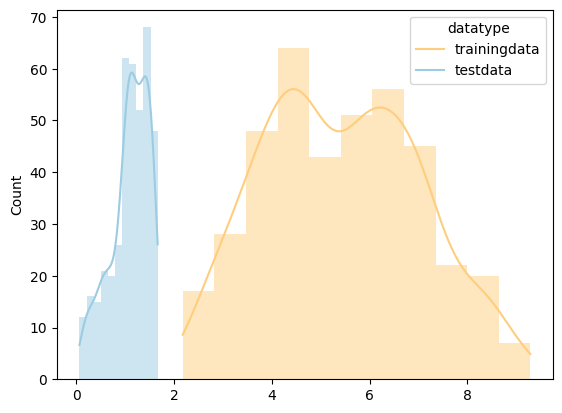

Using minmax scaler...


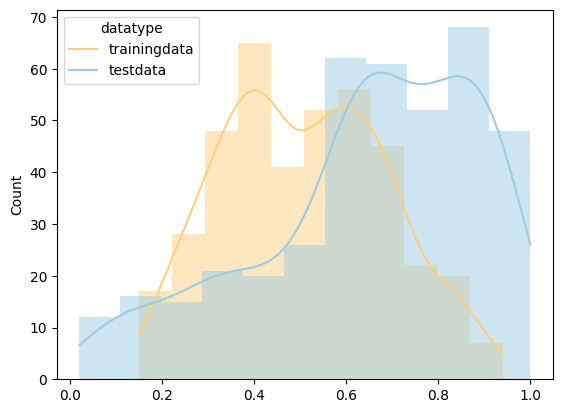

training data shape is  (5000, 401) 
test data shape is  (300, 401)
Start training


100%|██████████| 128/128 [00:46<00:00,  2.76it/s]


Training is done
prediction loss is:


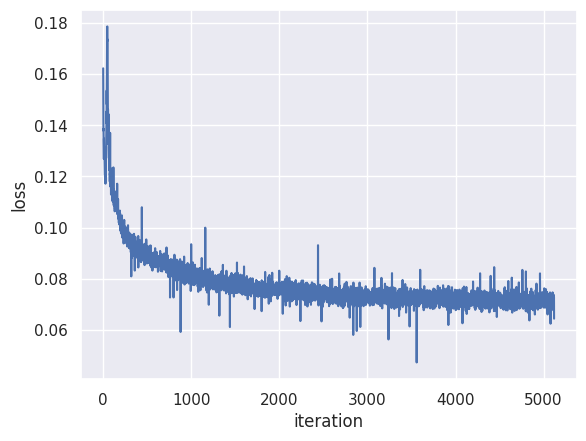

reconstruction loss is:


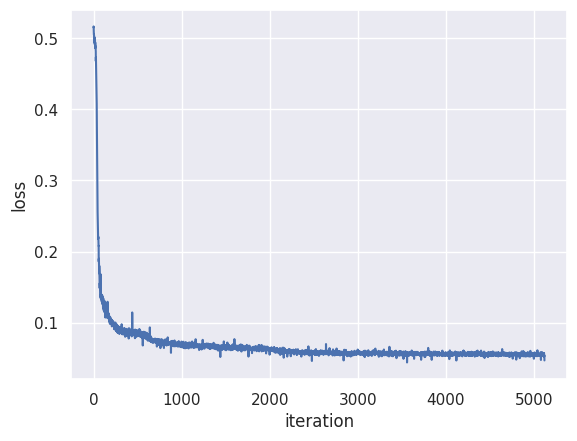

Notice that you are using parameters: mode=overall and adaptive=True
Model is saved without defined name
Start adaptive training for all the samples
Adaptive stage is done


In [28]:
SignatureMatrix, CellFractionPrediction = \
    Deconvolution(signature.T, pseudobulk, sep='\t', scaler='mms',
                  datatype='counts', genelenfile=None,
                  mode='overall', adaptive=True, variance_threshold=0.98,
                  save_model_name=None,
                  batch_size=128, epochs=128, seed=1)

In [29]:
SignatureMatrix

,ENSG00000165646,ENSG00000171051,ENSG00000158869,ENSG00000168685,ENSG00000263961,ENSG00000150045,ENSG00000128016,ENSG00000042980,ENSG00000149212,ENSG00000203747,...,ENSG00000116824,ENSG00000066923,ENSG00000125538,ENSG00000157404,ENSG00000128218,ENSG00000011600,ENSG00000204482,ENSG00000211956,ENSG00000139289,ENSG00000104951
B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CD4T,3.985977,0.295768,1.469075,1.062299,3.886134,0.000000,1.773820,0.348140,0.617144,0.543074,...,0.843858,0.094543,0.549002,3.992363,0.000000,1.448185,0.691752,0.622866,0.806490,0.126797
CD8T,0.372201,0.894551,1.162500,2.003737,0.000000,0.960975,1.676820,1.391112,1.414793,1.046160,...,1.924503,1.229192,0.788681,0.616161,1.405101,1.180568,1.125842,0.663053,1.418757,0.718243
DC,0.261544,1.121345,1.527597,1.262489,0.339033,0.540309,1.747477,1.097295,0.937516,0.840466,...,1.052528,0.671883,1.787910,0.502730,0.691678,1.674143,1.582489,0.918521,0.879452,1.319815
Mast,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Mono,0.000000,1.400075,0.681984,0.000000,0.000000,0.000000,0.244612,0.064290,0.072287,0.644720,...,0.000000,0.000000,0.881219,0.000000,0.000000,0.729551,1.015348,0.000000,0.246999,0.088208
NK,0.000000,0.224972,0.750993,0.578236,0.000000,1.529864,0.832438,0.498473,0.385860,1.024484,...,0.612774,0.408309,0.334677,0.000000,0.293615,0.769049,0.379549,0.290736,0.528724,0.169868
Plasma,0.185895,0.358193,0.916843,1.001261,0.259559,0.342858,1.475681,0.936838,0.572478,0.492929,...,0.790974,0.482644,0.612076,0.279878,1.010899,1.026169,0.694190,2.907172,0.530577,0.227575
Tregs,0.000000,0.752924,1.563733,2.117109,0.000000,0.812877,2.281766,1.506489,1.863312,1.107366,...,2.013878,1.415072,1.080329,0.000000,1.675079,1.663659,1.270059,1.287562,1.479726,0.836208


In [30]:
CellFractionPrediction

,B,CD4T,CD8T,DC,Mast,Mono,NK,Plasma,Tregs
0,0.165819,0.033075,0.232862,0.016706,0.0,0.189945,0.193772,0.0,0.167821
1,0.168470,0.028986,0.233510,0.017194,0.0,0.187198,0.192644,0.0,0.171997
2,0.166519,0.027041,0.232247,0.017336,0.0,0.191478,0.194454,0.0,0.170925
3,0.166971,0.028206,0.230616,0.019893,0.0,0.191238,0.192222,0.0,0.170855
4,0.167048,0.027021,0.233453,0.017412,0.0,0.193584,0.189039,0.0,0.172443
...,...,...,...,...,...,...,...,...,...
295,0.166348,0.031246,0.230602,0.018621,0.0,0.192062,0.190870,0.0,0.170250
296,0.163029,0.034103,0.228588,0.018606,0.0,0.193612,0.193354,0.0,0.168707
297,0.168031,0.026808,0.232853,0.018378,0.0,0.191824,0.191342,0.0,0.170765
298,0.165299,0.034652,0.228322,0.020095,0.0,0.189916,0.193074,0.0,0.168641


In [35]:
df_proportions = pd.DataFrame(np.stack([proportions[i].values for i in range(len(proportions))]),
                                    index=pseudobulk.index,
                                    columns=list(proportions[0].index))

In [70]:
df_proportions.mean(axis=0)

CD4T         0.269667
CD8T         0.184388
To remove    0.168020
B            0.135657
NK           0.089718
Mono         0.073625
Tregs        0.037048
Plasma       0.024218
Mast         0.010462
DC           0.007197
dtype: float64

In [39]:
corr_tape = compute_correlations(df_proportions, CellFractionPrediction)

In [44]:
corr_tape["correlations"].mean()

0.2712395305496138

In [ ]:
Pred = ScadenDeconvolution(signature, pseudobulk, sep='\t',
                           batch_size=128, epochs=128)

In [65]:
genes = np.intersect1d(pseudobulk.columns, signature.index)

input_data = pseudobulk.loc[:, genes].T

SignatureMatrix.shape, signature.shape, pseudobulk.shape, input_data.shape

((9, 401), (410, 9), (300, 29871), (410, 300))

In [67]:
deconv_results = perform_nnls(signature, input_data.T)

In [10]:
# import pandas as pd

# df = pd.read_csv("/home/owkin/Tabula_Sapiens_metadata.csv", index_col=0)
# df = df[df["method"]=="10X"]
# # (df["cell_ontology_class"].value_counts(normalize=True).to_frame() * 100).to_csv("TS_cell_freq.csv")
# columns_to_combine = ["organ_tissue", "cell_ontology_class"]
# combination_frequencies = df.groupby(columns_to_combine).size().reset_index(name='frequency')
# total_combinations = len(df)
# combination_frequencies['normalized_frequency'] = combination_frequencies['frequency'] / total_combinations
# combination_frequencies.to_csv("TS_cell_organ_combo_freq.csv")